## Binary classifiction with backpropagation model

## Some important imports and plot setup

In [50]:
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
# imports used by the resnet implementation
from torch.nn import init
import math


import numpy as np
import pandas as pd
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 20

print(pd.__version__)

0.20.3


## Data preprocessing

In [70]:
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.utils import shuffle
import re

# ok        
def preprocessor_libsvm_data(filename, format_label_func=lambda _: _):
    with open('./uci/' + filename + '.data', 'r') as inputfile:
        features = []
        labels = []
        for line in inputfile:
            container = line.rstrip().split()
            label = float(container[0])
            label = int(format_label_func(label))
            del container[0]
            pattern = re.compile(r"[-+]?\d+:([-+]?\d*\.\d+|[-+]?\d+)")
            feature = []
            for phrase in container:
                # print(phrase)
                target = re.findall(pattern, phrase)
                # print(target)
                feature.append(float(target[0]))
            features.append(feature)
            labels.append(label)
        classes = list(set(labels))
        for i in range(len(labels)):
            if labels[i] == classes[0]:
                labels[i] = 1
            else:
                labels[i] = 0
        features = np.array(features)
        labels = np.array(labels).reshape((-1,1))
        labels = labels.astype(np.float)
        data = np.concatenate((features,labels),axis=1)
        return data

In [71]:
data = preprocessor_libsvm_data("diabetes")
data = pd.DataFrame(data)
data[[8]] = data[[8]].astype('int')
data

,0,1,2,3,4,5,6,7,8
0,6.0,148.0,72.0,35.0,0.0,33.599998,0.627,50.0,0
1,1.0,85.0,66.0,29.0,0.0,26.600000,0.351,31.0,1
2,8.0,183.0,64.0,0.0,0.0,23.299999,0.672,32.0,0
3,1.0,89.0,66.0,23.0,94.0,28.100000,0.167,21.0,1
4,0.0,137.0,40.0,35.0,168.0,43.099998,2.288,33.0,0
5,5.0,116.0,74.0,0.0,0.0,25.600000,0.201,30.0,1
6,3.0,78.0,50.0,32.0,88.0,31.000000,0.248,26.0,0
7,10.0,115.0,0.0,0.0,0.0,35.299999,0.134,29.0,1
8,2.0,197.0,70.0,45.0,543.0,30.500000,0.158,53.0,0
9,8.0,125.0,96.0,0.0,0.0,0.000000,0.232,54.0,0


## Visualization

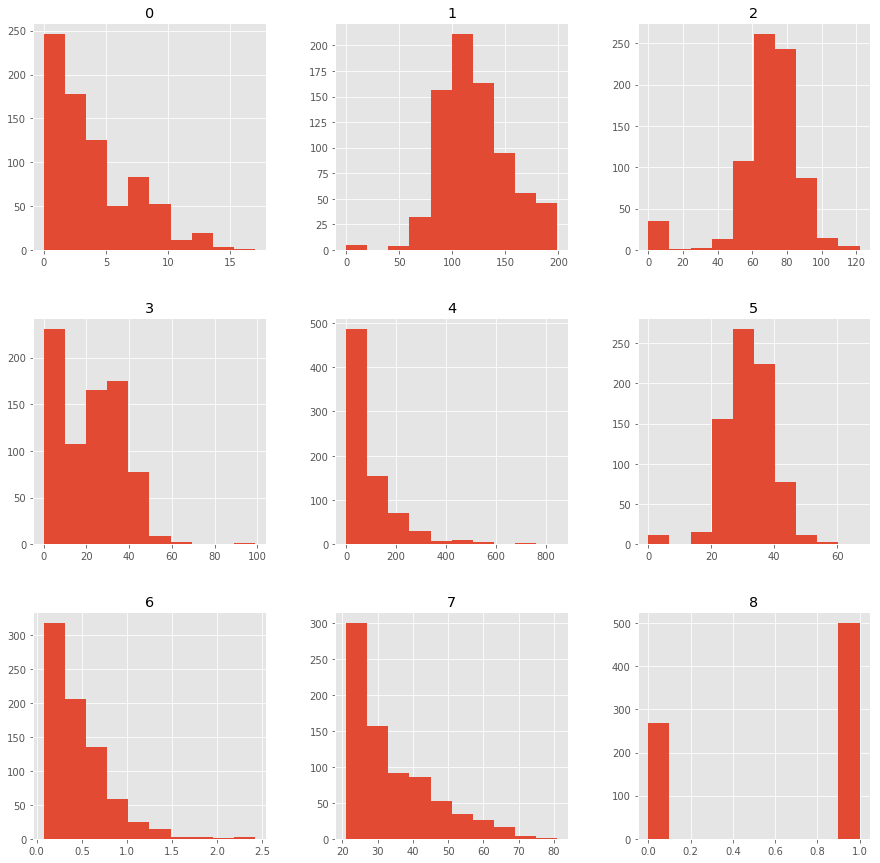

In [72]:
# Histogram of original dataframe
# plots in alphabetical order (unfortunately)
pd.DataFrame.hist(data=data, figsize=[15,15]);

## Data process

In [73]:
# randomly split data set into train and test sets
from sklearn.model_selection import train_test_split

X_data = data.loc[:, :7].values
y_data = data.loc[:, 8].values

HOLDOUT_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_data, 
                                                    test_size=HOLDOUT_SPLIT,
                                                    shuffle=True,
                                                    random_state=42)

# transform to column vectors
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print('Original data points: {}'.format(np.shape(X_data)[0]))
print('Test split: {}%'.format(HOLDOUT_SPLIT*100))
print('Training points: {}, Test points: {}'.format(np.shape(X_train)[0], 
                                                    np.shape(X_test)[0]))


# Precompute normalization of k-fold train/val sets for inputs
# Use scale by median and IQR (aka 'robust scaling')
# Leave outputs as binary

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

import torch
from torch.autograd import Variable


K_FOLDS = 5

cv_data = [[]]*K_FOLDS
index = 0

kf = KFold(n_splits=K_FOLDS)
for train_loc, val_loc in kf.split(X_train):
    # create robust scaler for input
    scale_in = RobustScaler().fit(X_train[train_loc])
    
    # train data for each fold
    X_train_scale = scale_in.transform(X_train[train_loc])
    y_train_scale = y_train[train_loc]  # don't scale binary
    
    # validation data for each fold
    X_val_scale = scale_in.transform(X_train[val_loc])
    y_val_scale = y_train[val_loc]
    
    # store to unpack later - could be more efficient?
    cv_data[index] = (
         Variable(torch.FloatTensor(X_train_scale), requires_grad=False),
         Variable(torch.FloatTensor(X_val_scale), requires_grad=False),
         Variable(torch.FloatTensor(y_train_scale), requires_grad=False),         
         Variable(torch.FloatTensor(y_val_scale), requires_grad=False)
    )
    
    index += 1

print('Number of folds: {}'.format(K_FOLDS))
print('Train points: {}'.format(np.size(train_loc)))
print('Val points: {}'.format(np.size(val_loc)))

Original data points: 768
Test split: 20.0%
Training points: 614, Test points: 154
Number of folds: 5
Train points: 492
Val points: 122


In [74]:
# create robust scaler for input
scale_in = RobustScaler().fit(X_train)

# all of train data
X_train_scale = scale_in.transform(X_train)
y_train_scale = y_train  # don't scale binary

# all of test data
X_test_scale = scale_in.transform(X_test)
y_test_scale = y_test

# prepare for PyTorch
X_train_tor = Variable(torch.FloatTensor(X_train_scale), requires_grad=False)
X_test_tor = Variable(torch.FloatTensor(X_test_scale), requires_grad=False)
y_train_tor = Variable(torch.FloatTensor(y_train_scale), requires_grad=False)         
y_test_tor = Variable(torch.FloatTensor(y_test_scale), requires_grad=False)

print('Train points: {}'.format(np.size(y_train_scale)))
print('Test points: {}'.format(np.size(y_test_scale)))

Train points: 614
Test points: 154


## Neural Network

In [75]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(torch.nn.Module):
    # list of hyperparameters to tune
    INPUT_SIZE = 8
    OUTPUT_SIZE = 1
    L2_PEN = 1e-6
    NUM_EPOCHS = 801
    H1_SIZE = 1024
    H2_SIZE = 64
    H3_SIZE = 64
    H1_DROPOUT = 0.9
    LR = 0.1
    
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = nn.Sequential(nn.Linear(Net.INPUT_SIZE, Net.H1_SIZE, bias=True),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Dropout(p=Net.H1_DROPOUT))
        self.h2 = nn.Sequential(nn.Linear(Net.H1_SIZE, Net.H2_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.h3 = nn.Sequential(nn.Linear(Net.H2_SIZE, Net.H3_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.output = nn.Sequential(nn.Linear(Net.H3_SIZE, Net.OUTPUT_SIZE, bias=False),
                                nn.Sigmoid())
        
    def forward(self, x):
        out = self.h1(x)
        out = self.h2(out)
        out = self.h3(out)
        out = self.output(out)
        
        return out
    
def accuracy(y_pred, y_true):
    correct = torch.sum((y_pred > 0.5).type(torch.FloatTensor) == y_true)
    total = y_true.size(0)
    return 100. * float(correct) / float(total)

## Train

Step: 0
	Train Accuracy: 2.9315960912052117
	Test Accuracy: 57.79220779220779
Step: 100
	Train Accuracy: 35.66775244299674
	Test Accuracy: 72.72727272727273
Step: 200
	Train Accuracy: 33.06188925081433
	Test Accuracy: 72.72727272727273
Step: 300
	Train Accuracy: 33.876221498371336
	Test Accuracy: 74.67532467532467
Step: 400
	Train Accuracy: 35.504885993485345
	Test Accuracy: 76.62337662337663
Step: 500
	Train Accuracy: 35.99348534201955
	Test Accuracy: 77.27272727272727
Step: 600
	Train Accuracy: 35.504885993485345
	Test Accuracy: 76.62337662337663
Step: 700
	Train Accuracy: 37.13355048859935
	Test Accuracy: 75.32467532467533
Step: 800
	Train Accuracy: 37.13355048859935
	Test Accuracy: 74.67532467532467


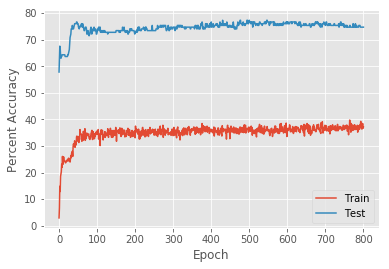

Final Train Accuracy: 37.13355048859935
Final Test Accuracy: 74.67532467532467


In [76]:
VERBOSE = True

final_net = Net()
final_net.train()

# optimizer = torch.optim.Adam(net.parameters(), weight_decay=Net.L2_PEN, lr=Net.LR)
optimizer = torch.optim.SGD(final_net.parameters(), 
                            weight_decay=Net.L2_PEN, 
                            lr=Net.LR,
                            momentum=0.0,
                            dampening=0.0,
                            nesterov=False)
loss_func = torch.nn.BCELoss()

epochs = np.arange(Net.NUM_EPOCHS)
hist_loss_train = np.zeros(Net.NUM_EPOCHS)
hist_loss_test = np.zeros(Net.NUM_EPOCHS)
hist_correct_train = np.zeros(Net.NUM_EPOCHS)
hist_correct_test = np.zeros(Net.NUM_EPOCHS)

for step in range(Net.NUM_EPOCHS):
    # Show improvement on test set
    final_net.eval()
    test_pred = final_net(X_test_tor)
    loss_test = loss_func(test_pred, y_test_tor)
    hist_loss_test[step] = loss_test
    hist_correct_test[step] = accuracy(test_pred, y_test_tor)

    # Perform train cost fn
    final_net.train()
    train_pred = final_net(X_train_tor)
    loss_train = loss_func(train_pred, y_train_tor)
    hist_loss_train[step] = loss_train
    hist_correct_train[step] = accuracy(train_pred, y_train_tor)

    if VERBOSE and ((step % 100) == 0):
        print('Step: {}'.format(step))
        print('\tTrain Accuracy: {}'.format(hist_correct_train[step]))
        print('\tTest Accuracy: {}'.format(hist_correct_test[step]))

    # Update based on train performance
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
plt.plot(epochs, hist_correct_train, epochs, hist_correct_test)
# plt.title('Final Test Accuracy'.format(fold))
plt.xlabel('Epoch')
plt.ylabel('Percent Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

print('Final Train Accuracy: {}'.format(hist_correct_train[-1]))
print('Final Test Accuracy: {}'.format(hist_correct_test[-1]))
# print('Mean cross validation performance: {}'.format(fold_mean))